# **Clone Repo and install dependencies**

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -qr yolov5/requirements.txt
%cd yolov5

import torch
from IPython.display import Image, clear_output
from utils.google_utils import gdrive_download

clear_output()

# **Download the dataset from Roboflow : [Link](https://public.roboflow.com/)**

In [ ]:
%cd /content
!curl -L "PASTE YOUR LINK HERE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
#extracting information from the roboflow file
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['smoke']

In [ ]:
# define number of classes based on data.yaml
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

# **Use a custom model configuration**

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# **Train on new dataset**

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', epochs=100, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, logdir='runs/', multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-10-16 11:29:35.882671: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 

# **Test on Images and Videos**

In [ ]:
!python detect.py --weights runs/exp0_yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.45, output='inference/output', save_txt=False, source='../test/images', update=False, view_img=False, weights=['runs/exp0_yolov5s_results/weights/best.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... 
Model Summary: 140 layers, 7.24652e+06 parameters, 0 gradients
image 1/74 /content/test/images/ck0kcoc8ik6ni0848clxs0vif_jpeg.rf.8b4629777ffe1d349cc970ee8af59eac.jpg: 352x416 1 smokes, Done. (0.012s)
image 2/74 /content/test/images/ck0kd4afx8g470701watkwxut_jpeg.rf.bb5a1f2c2b04be20c948fd3c5cec33ff.jpg: 352x416 1 smokes, Done. (0.013s)
image 3/74 /content/test/images/ck0kdhymna0b10721v4wntit8_jpeg.rf.a08e34d04fb672ce6cf8e94e810ec81d.jpg: 352x416 1 smokes, Done. (0.011s)
image 4/74 /content/test/images/ck0kepbs9kdym0848hgpcf3y9_jpeg.rf.d0a63becb54a83b6b026f4b38a42933b.jpg: 352x416 1 smokes, Done. (0.011s)
image 5/7

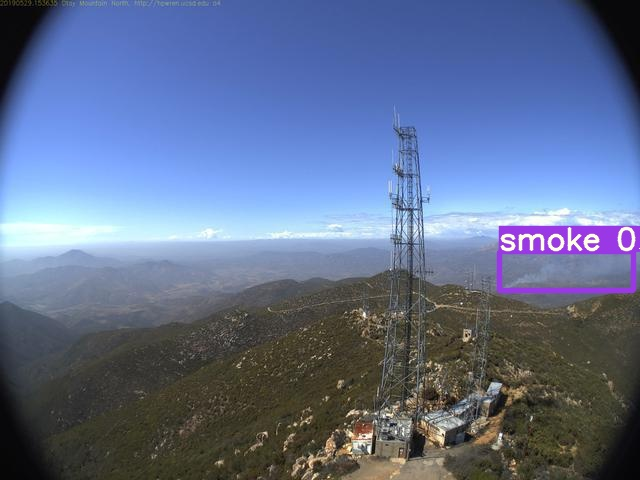

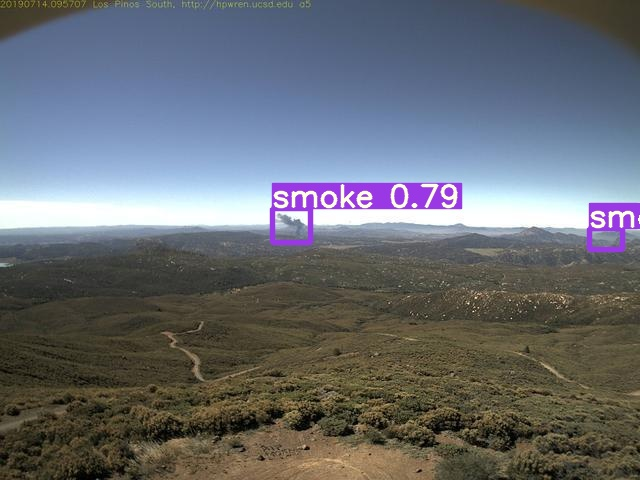

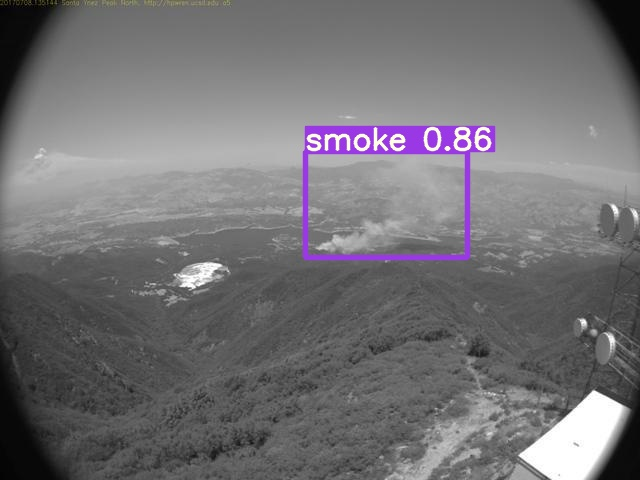

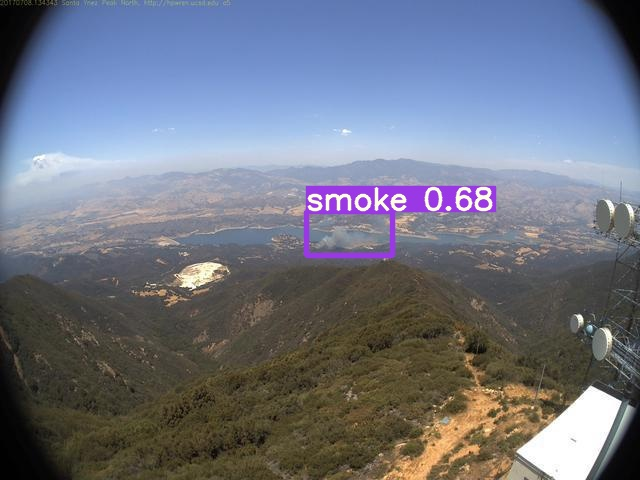

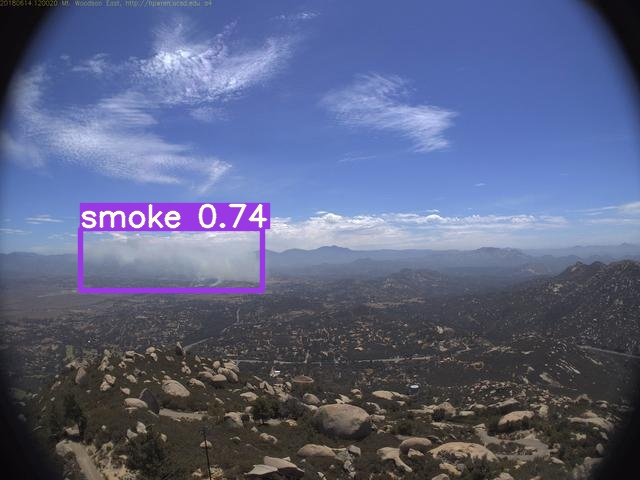

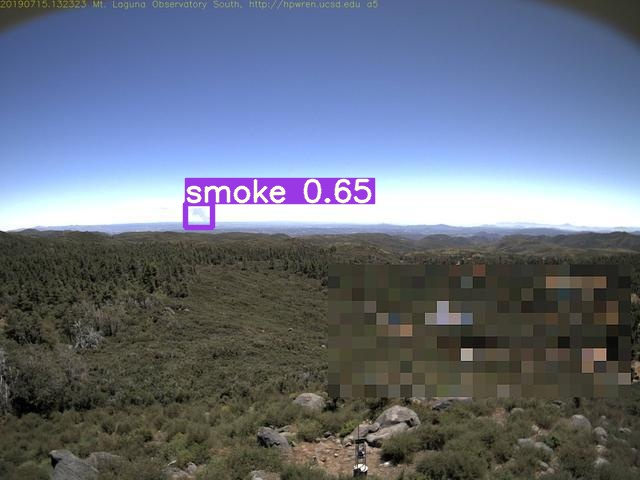

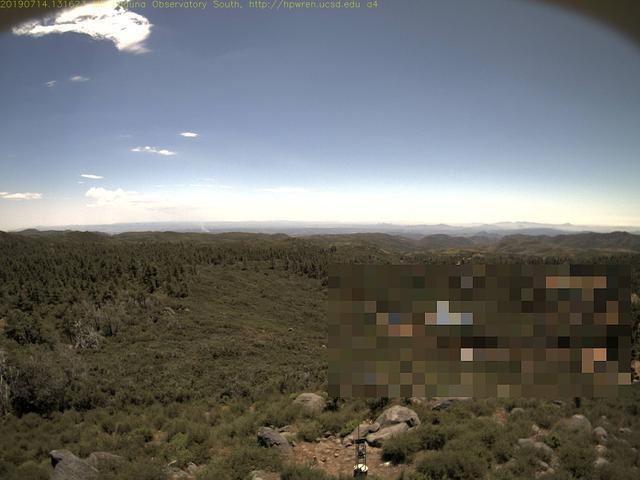

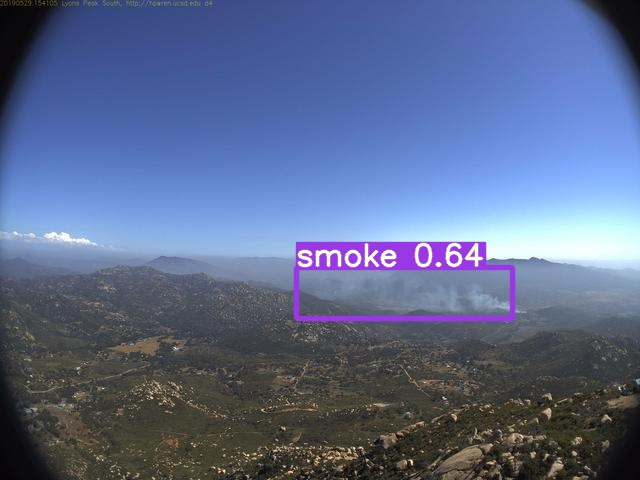

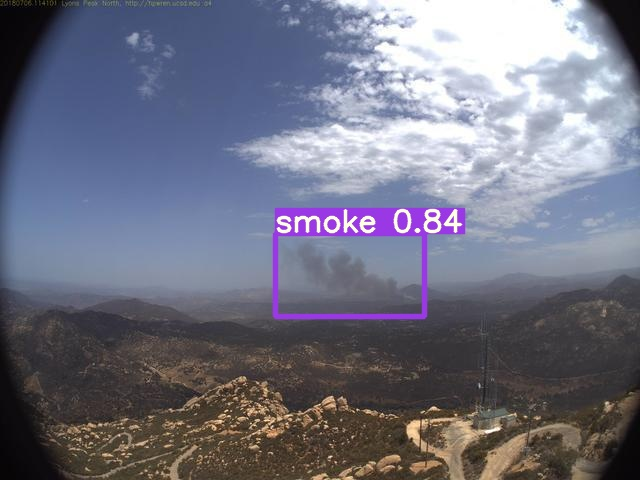

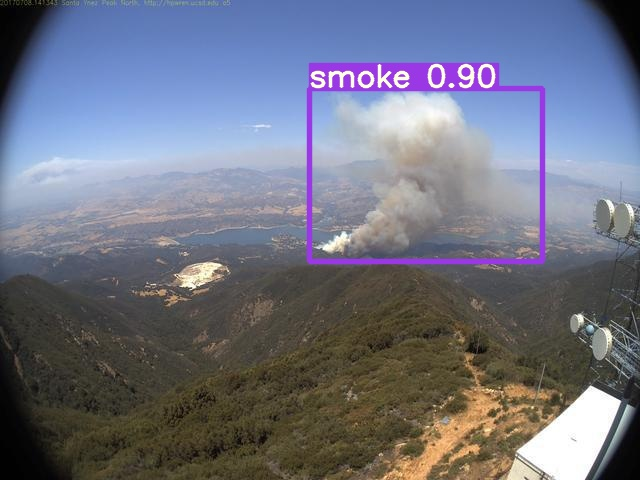

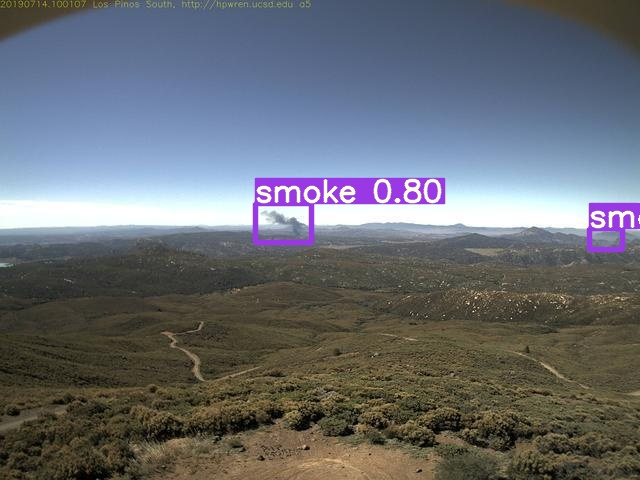

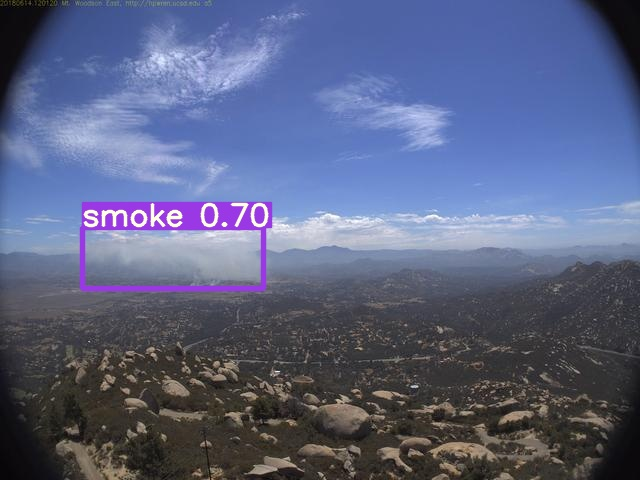

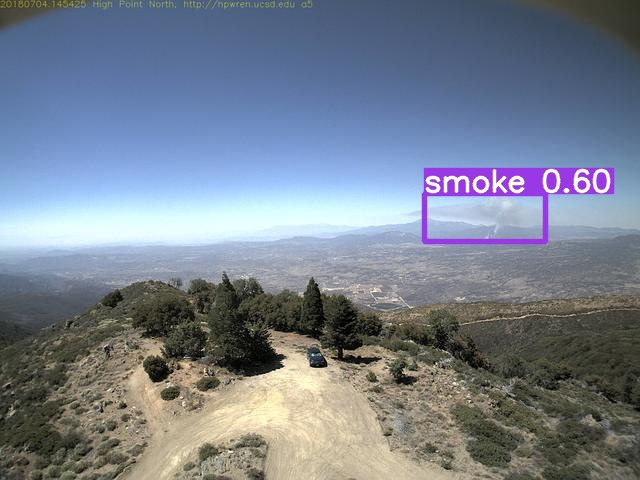

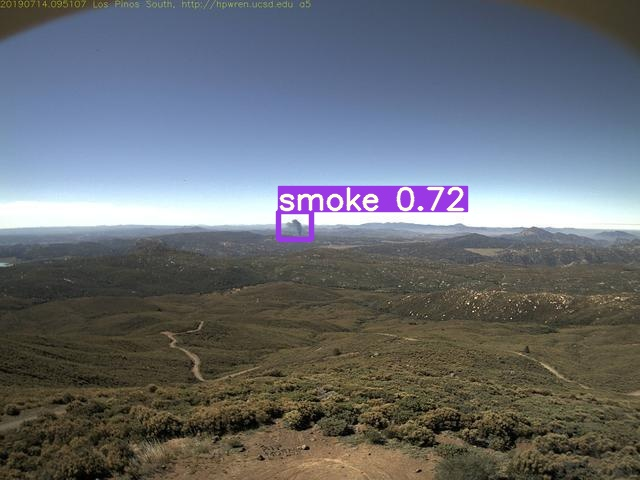

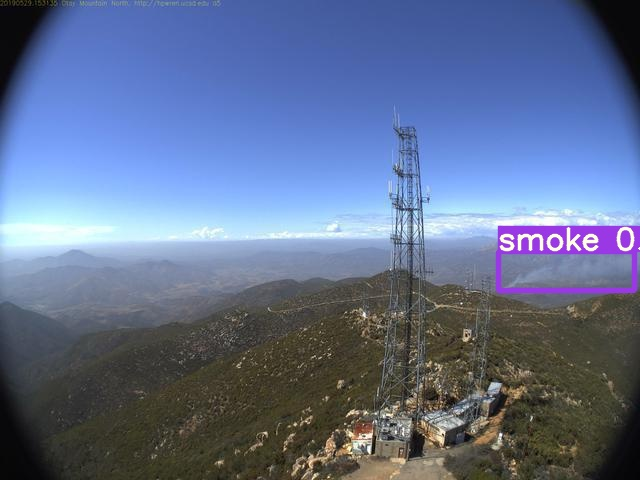

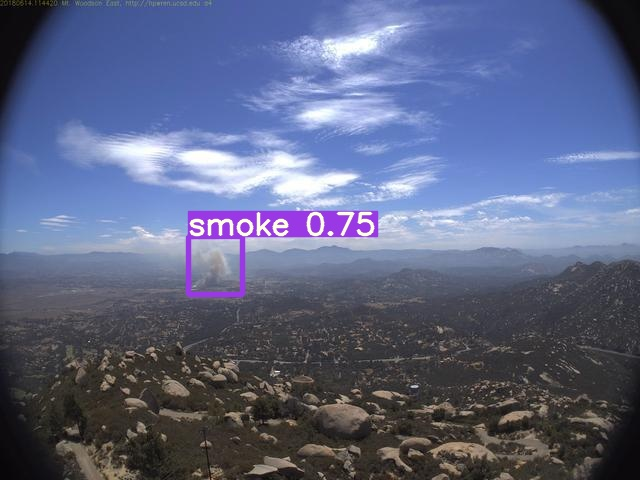

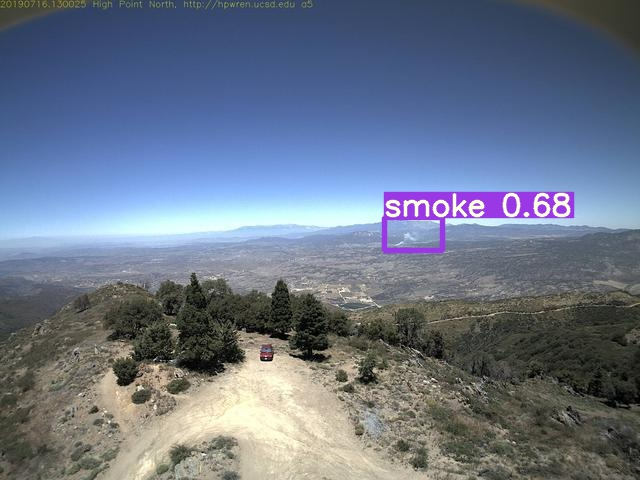

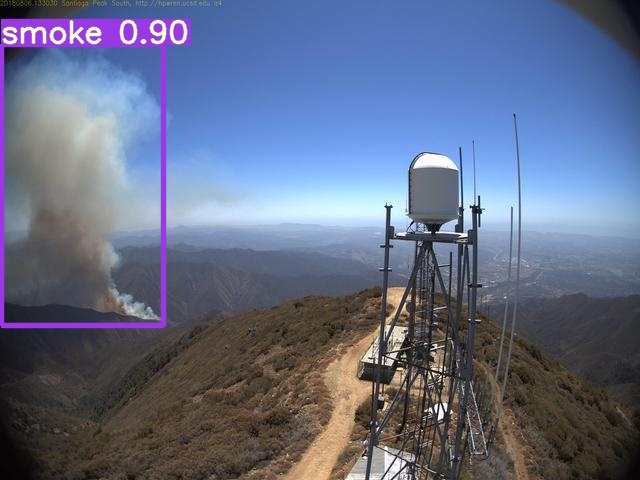

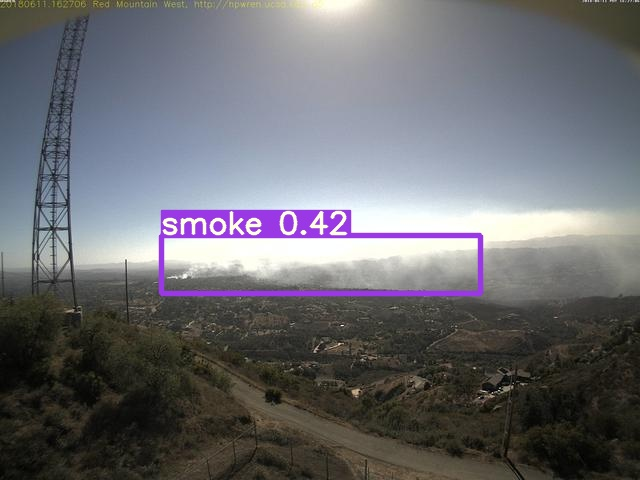

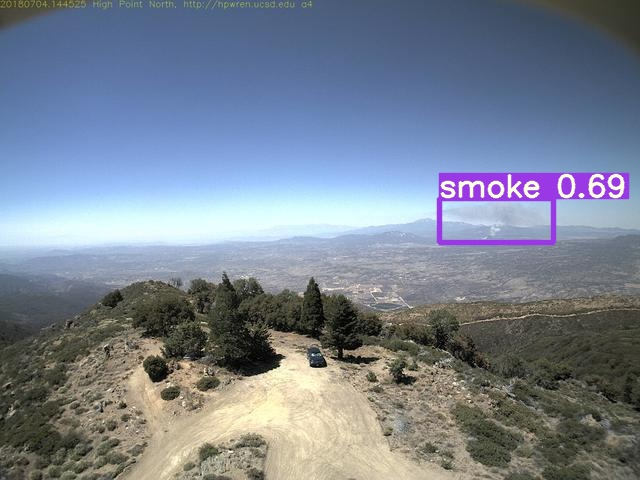

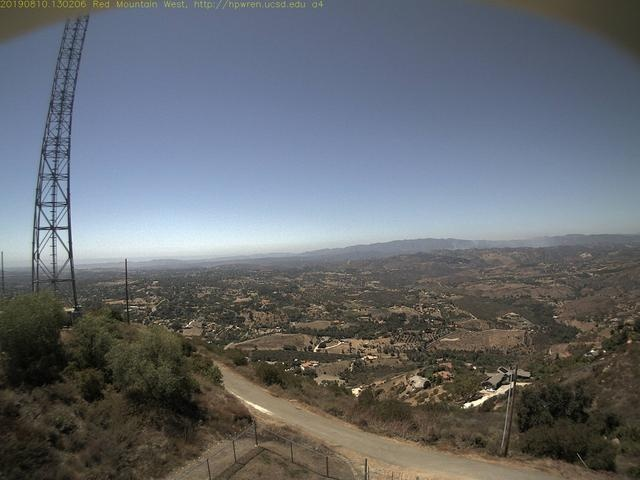

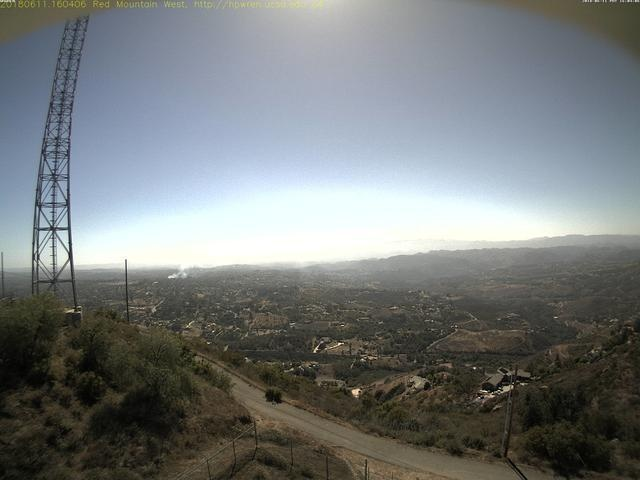

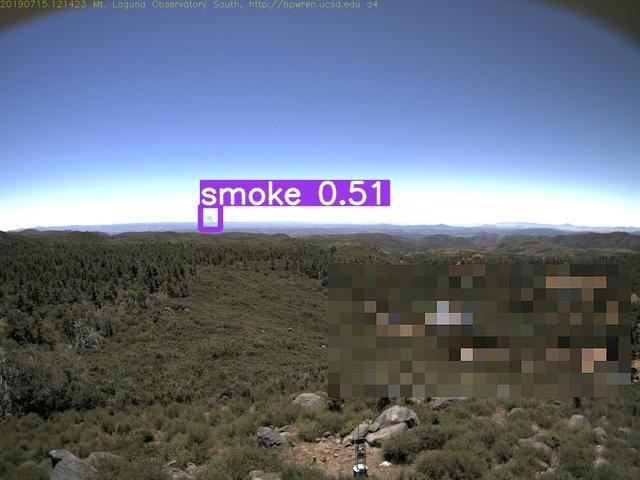

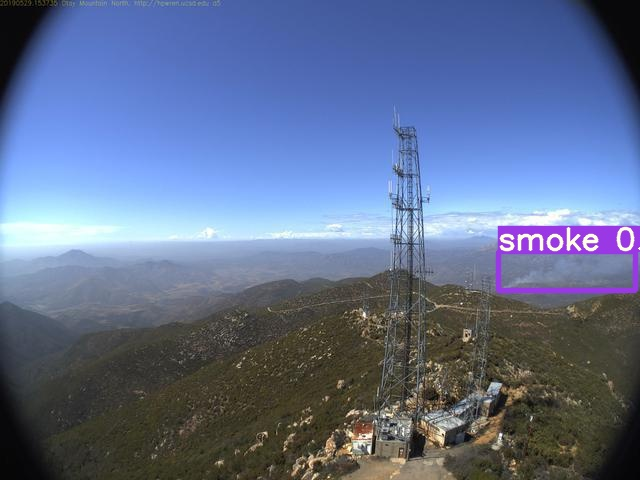

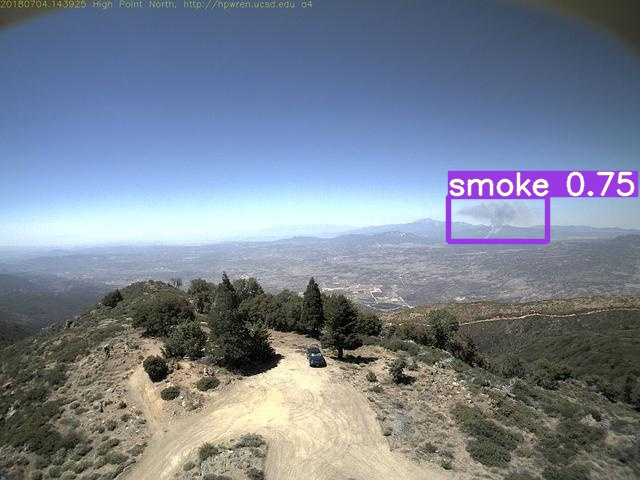

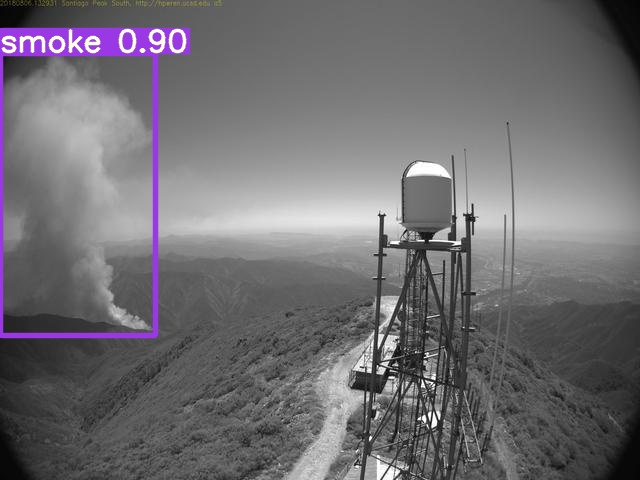

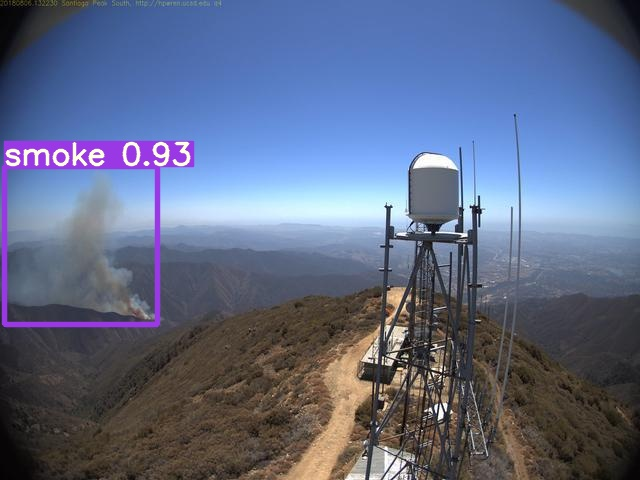

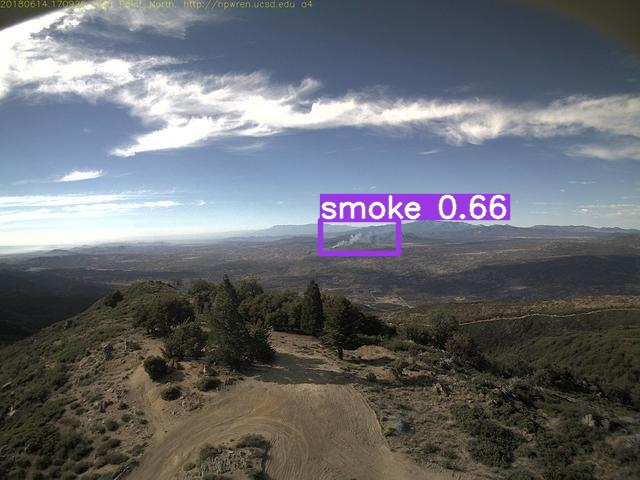

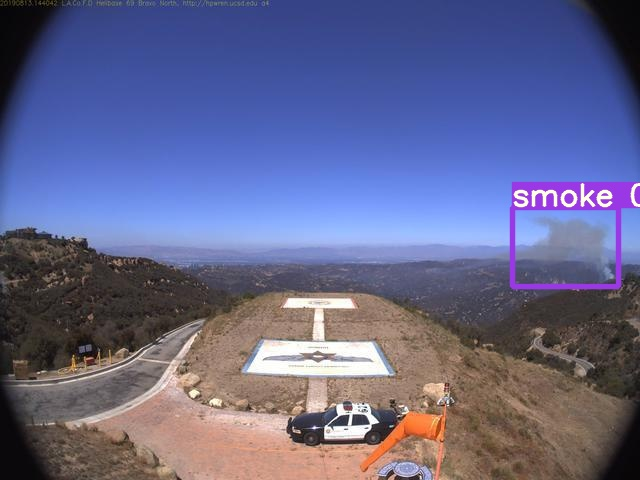

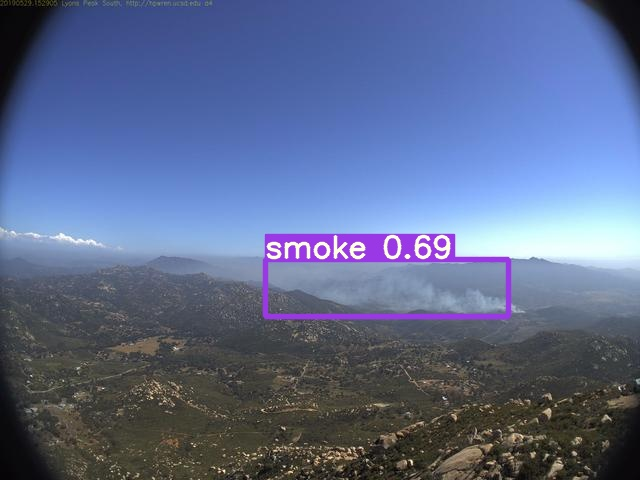

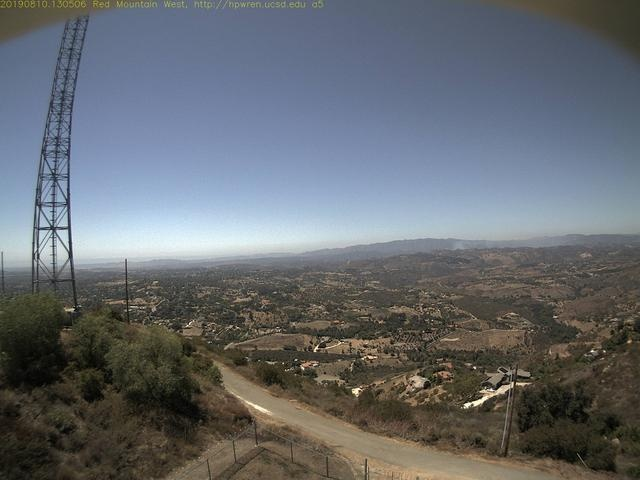

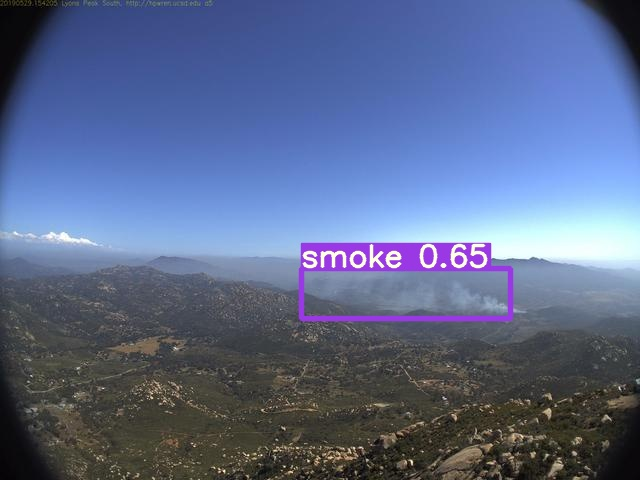

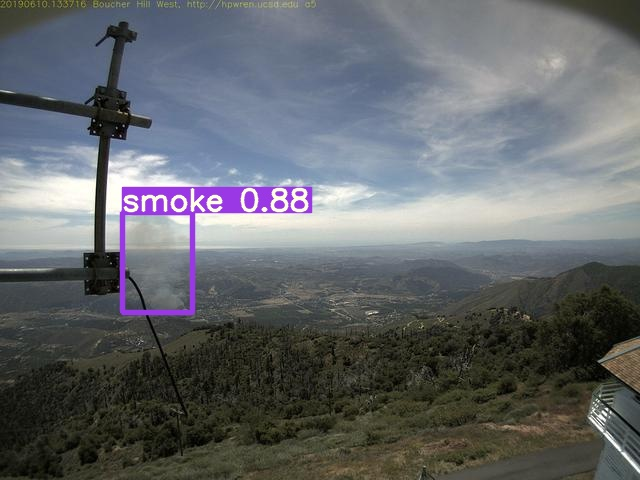

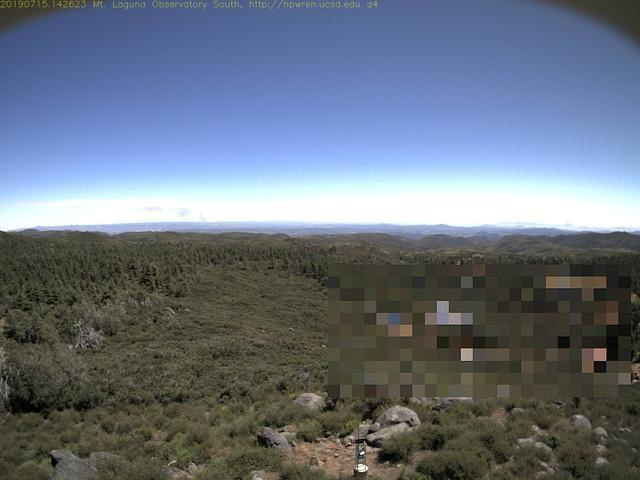

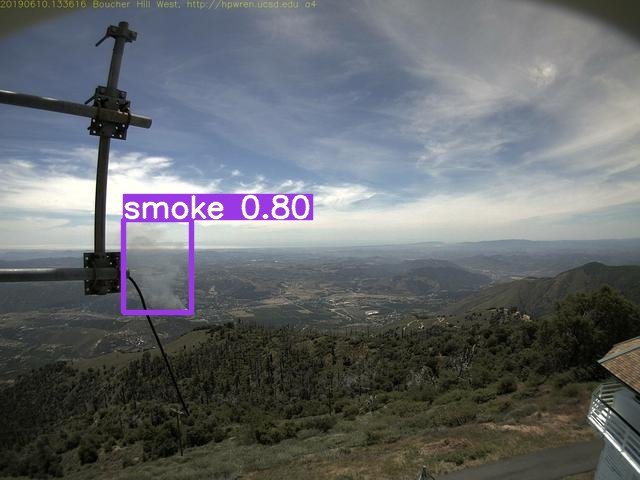

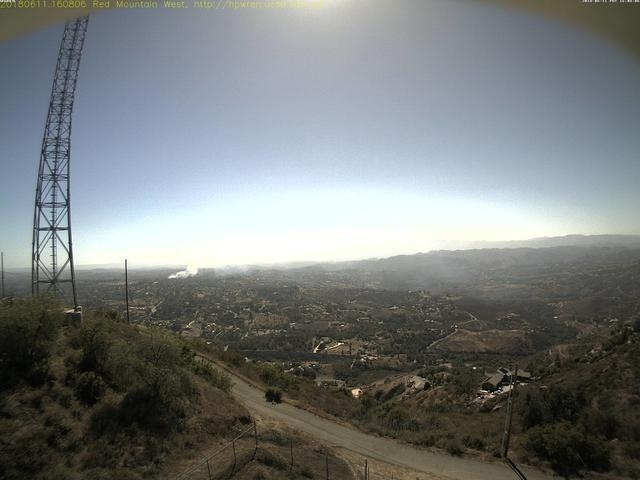

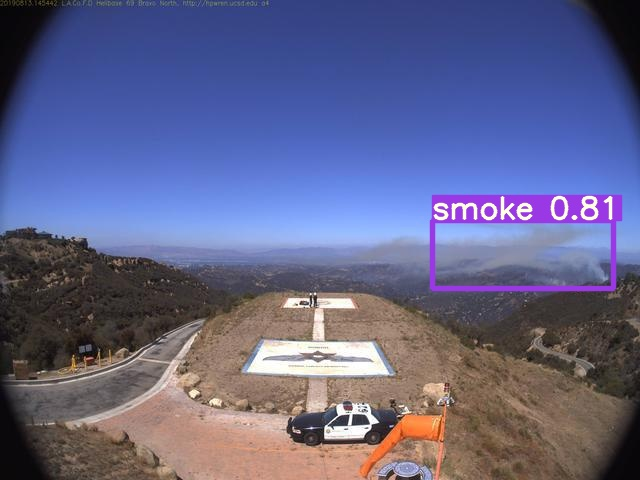

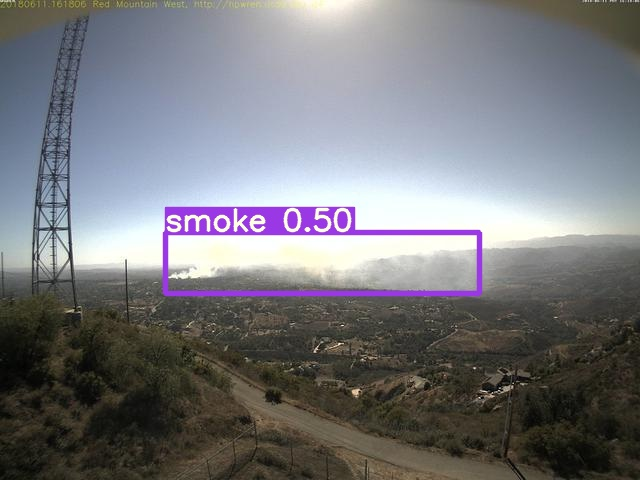

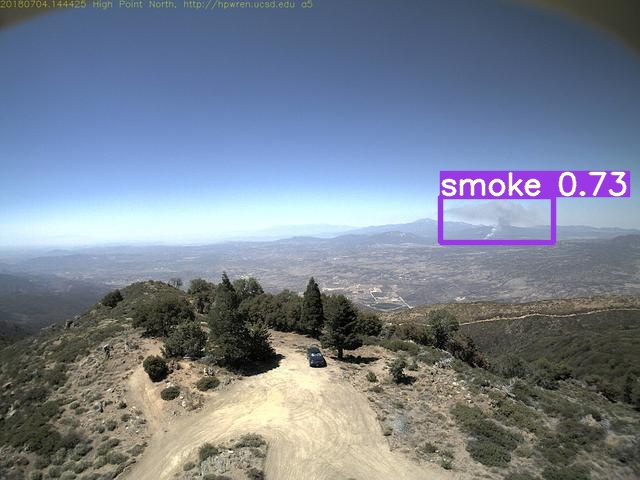

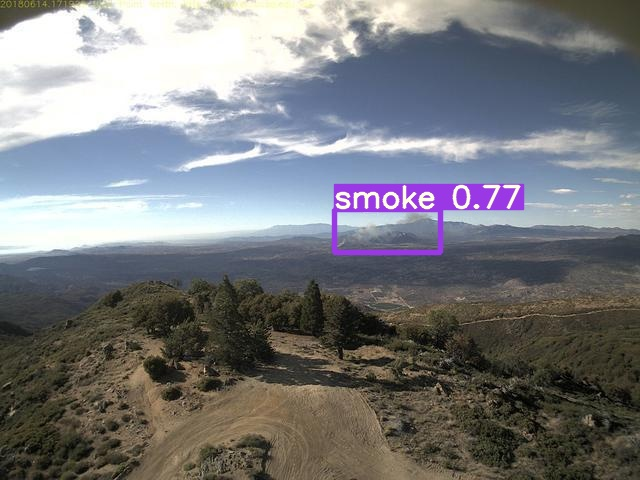

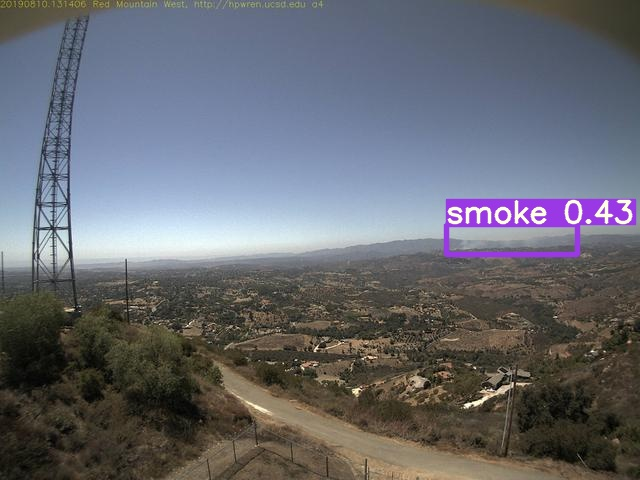

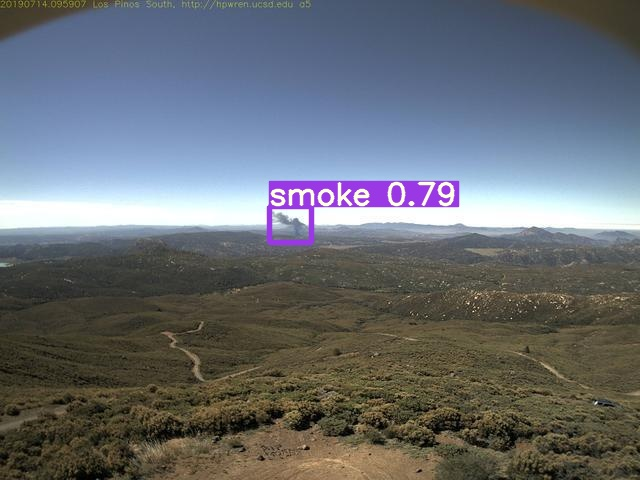

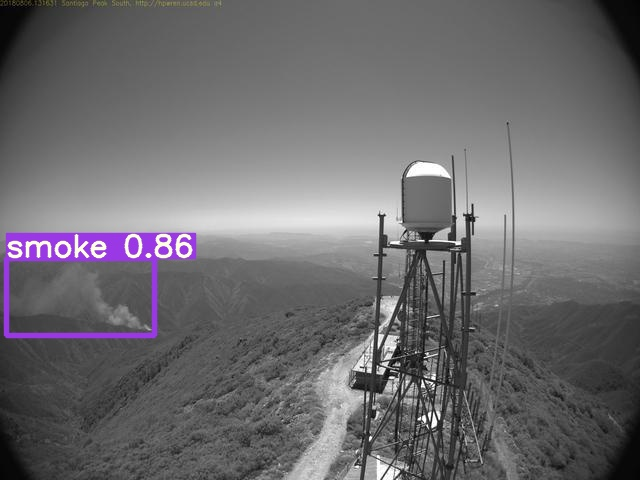

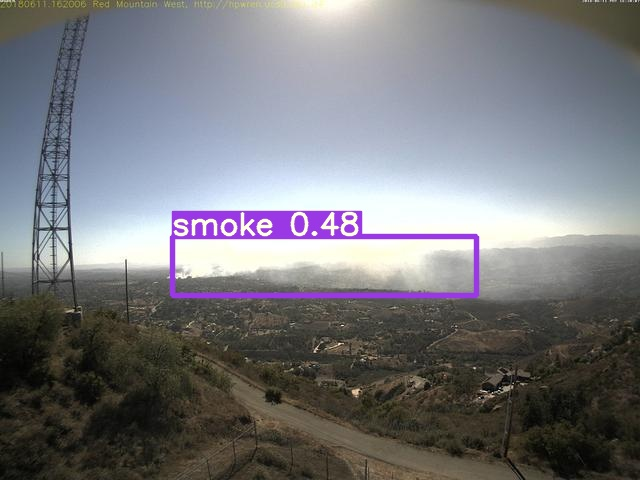

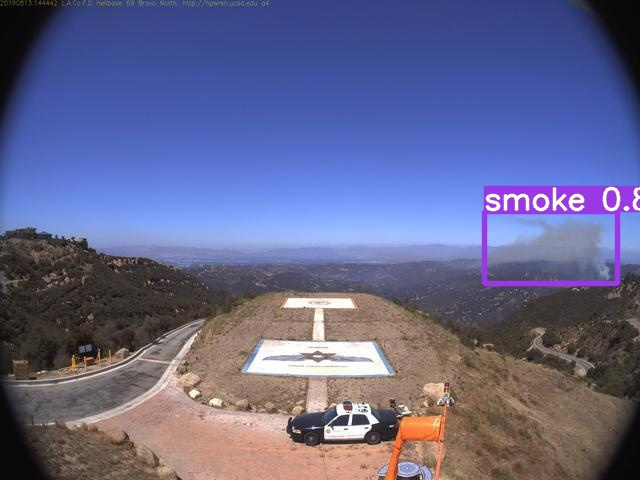

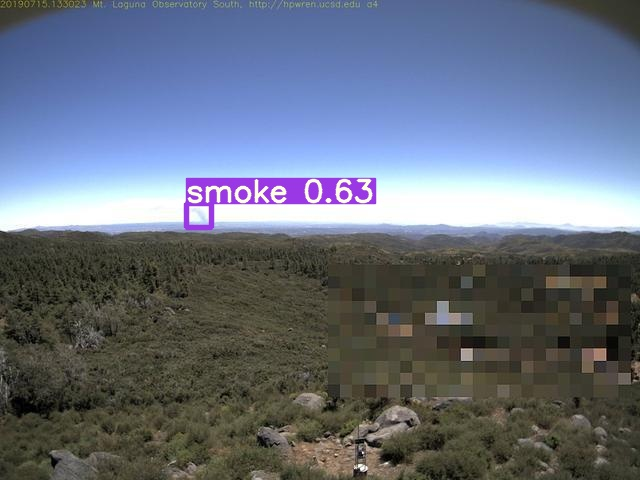

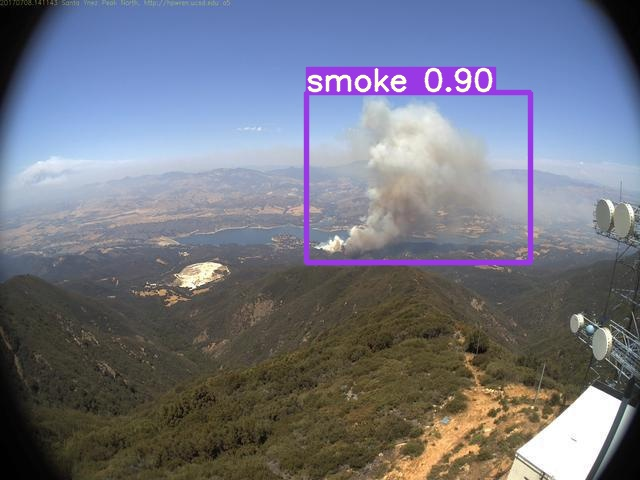

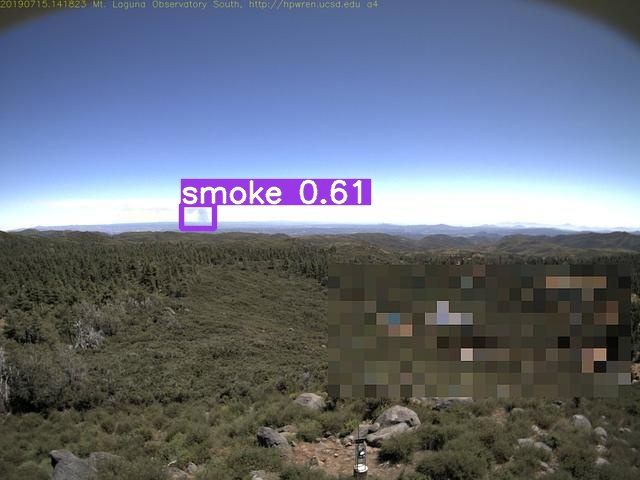

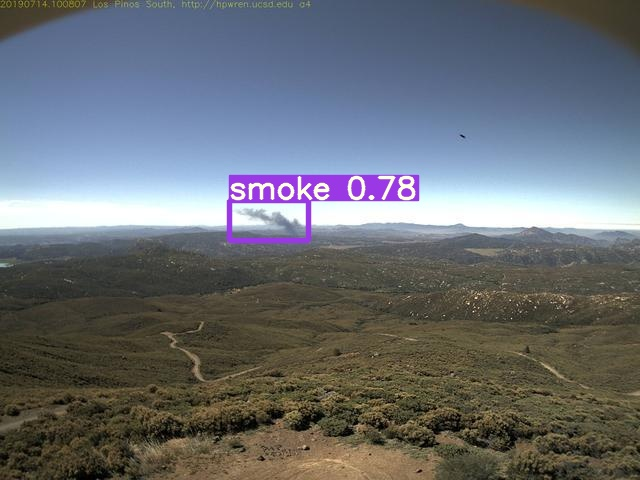

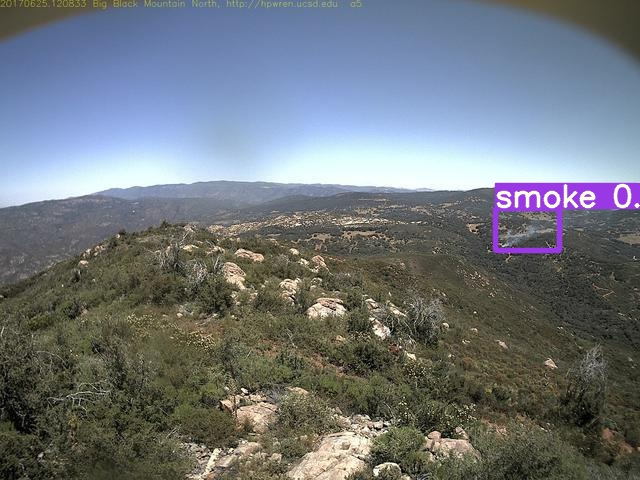

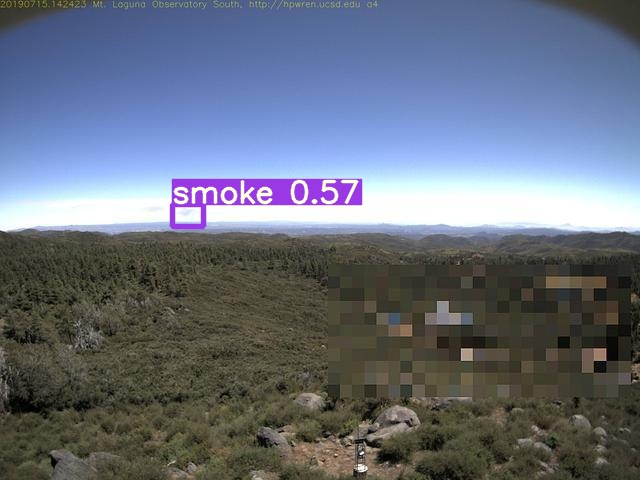

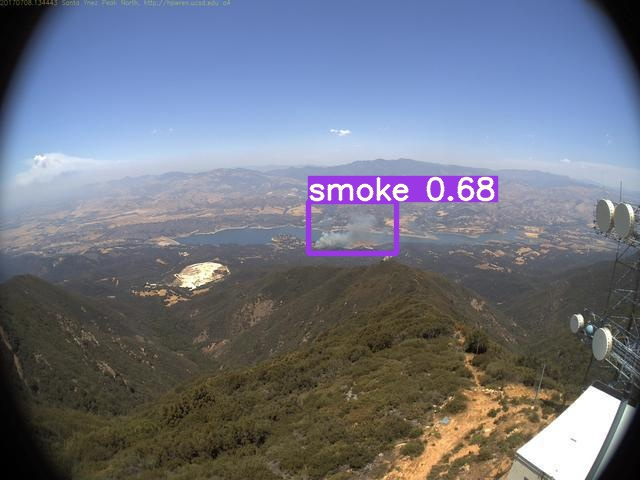

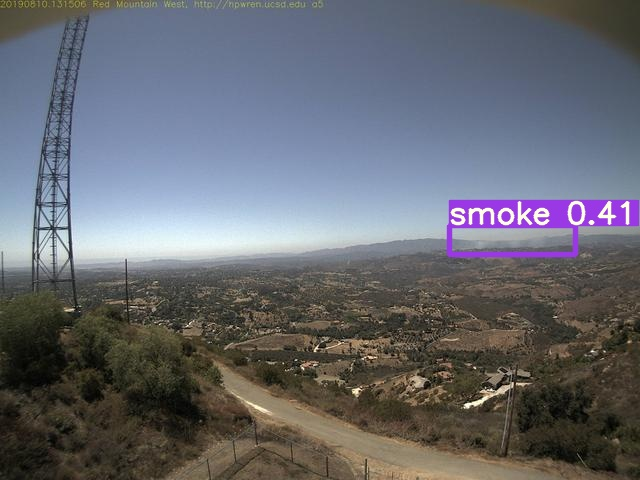

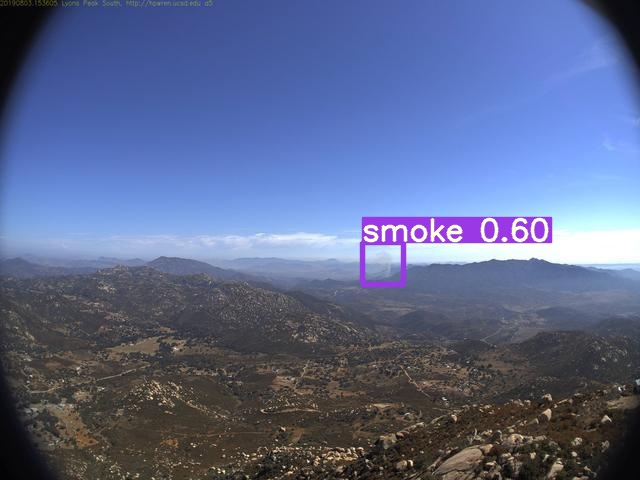

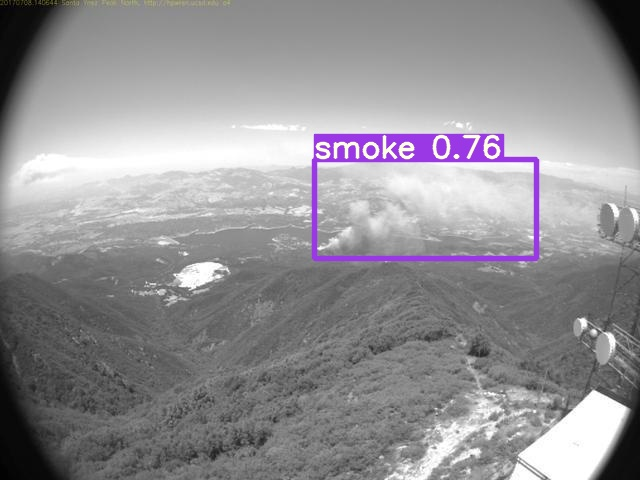

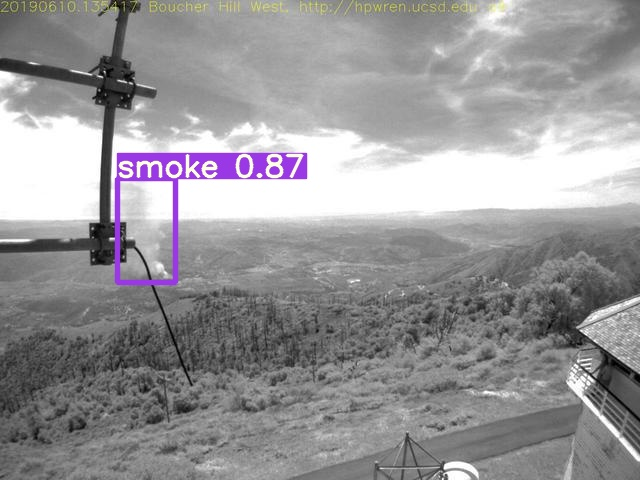

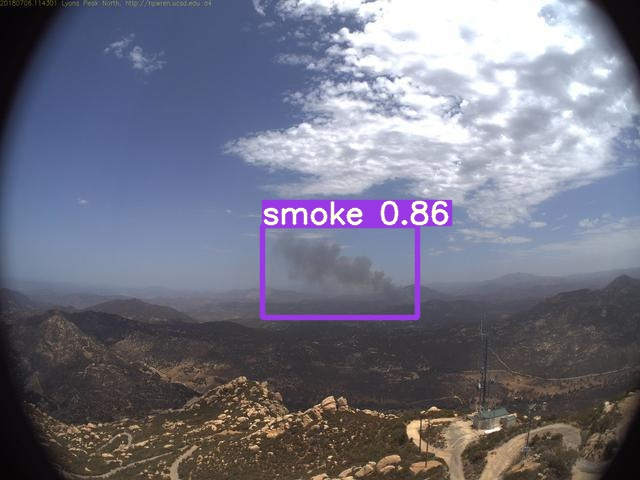

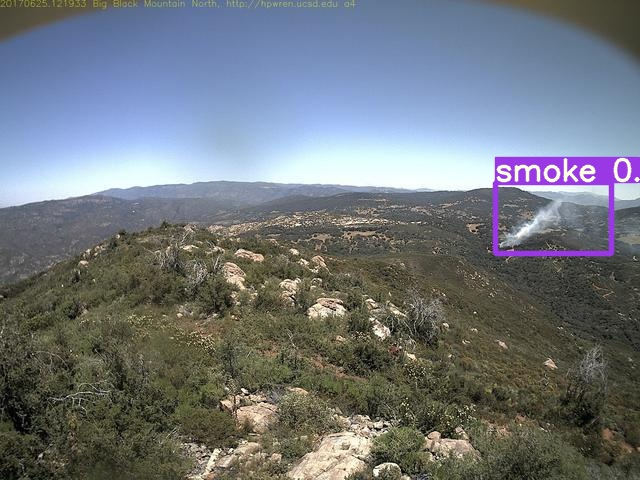

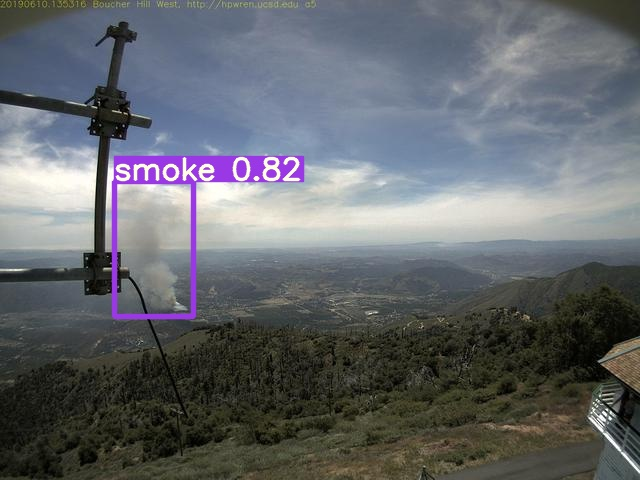

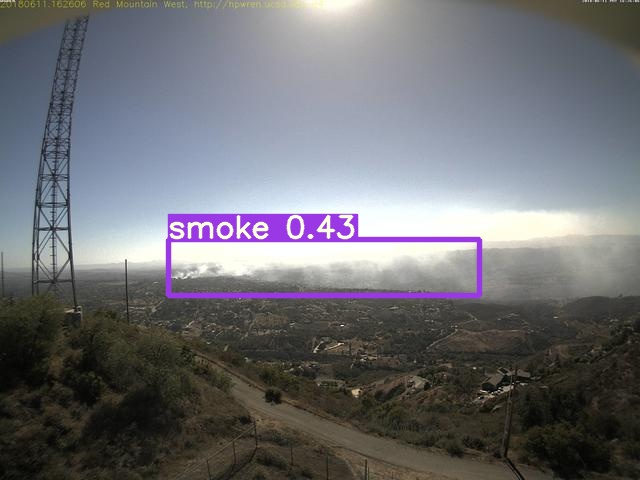

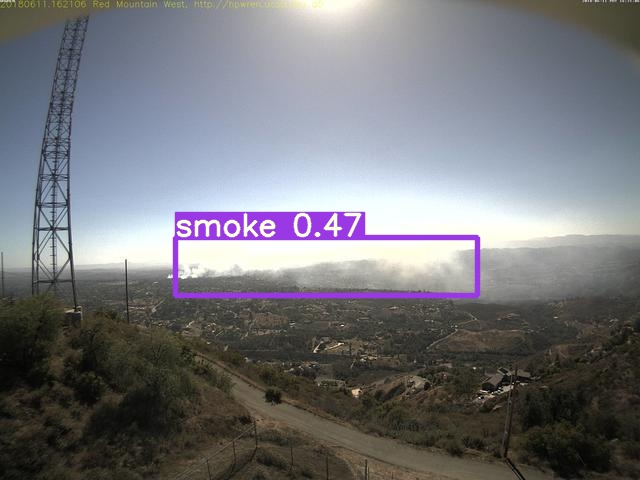

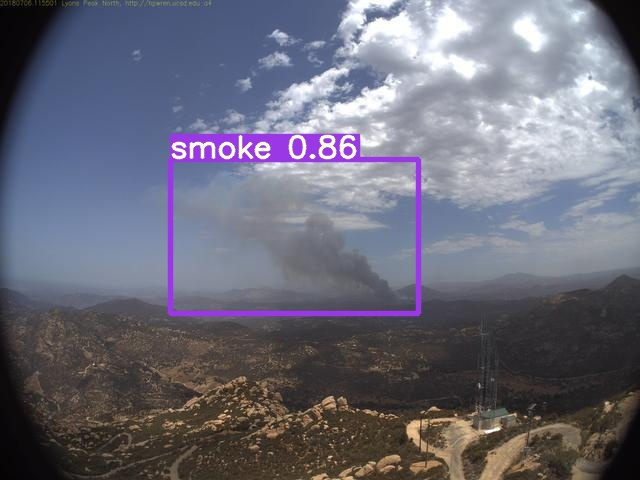

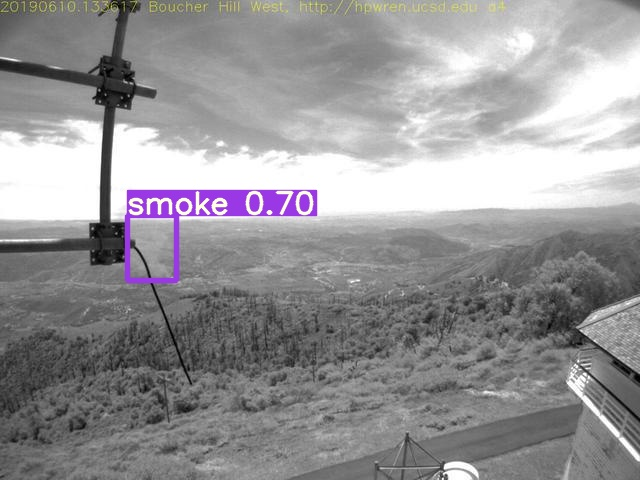

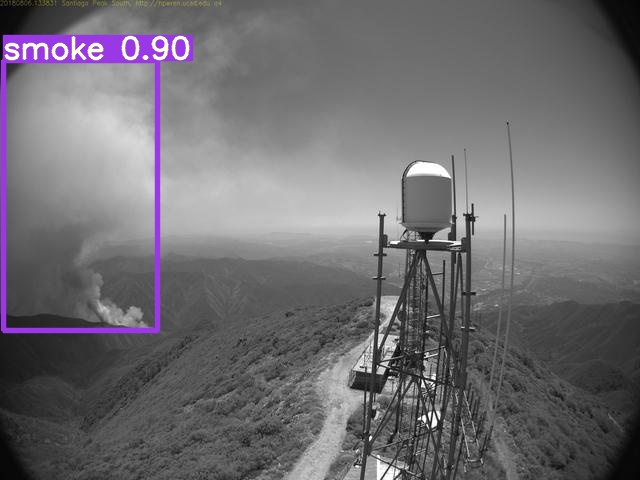

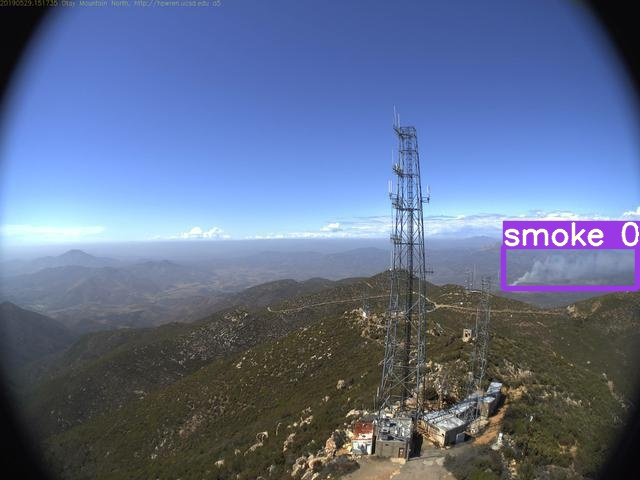

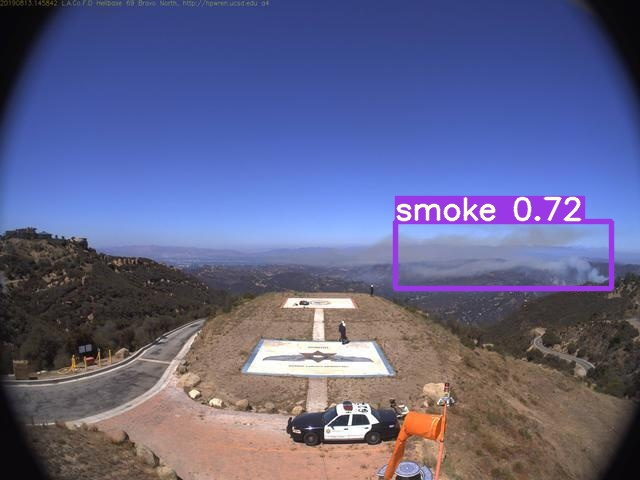

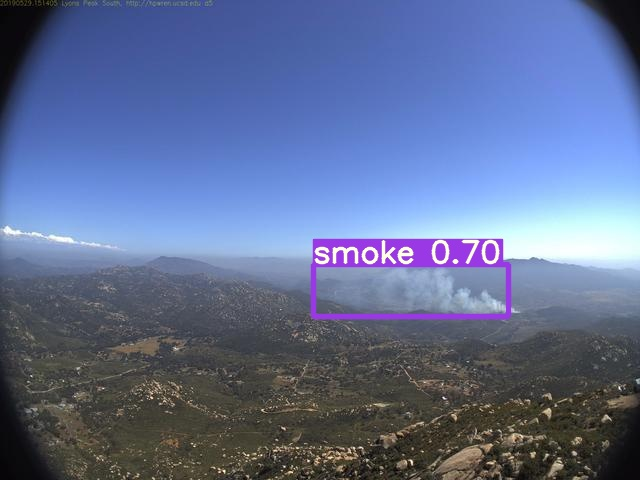

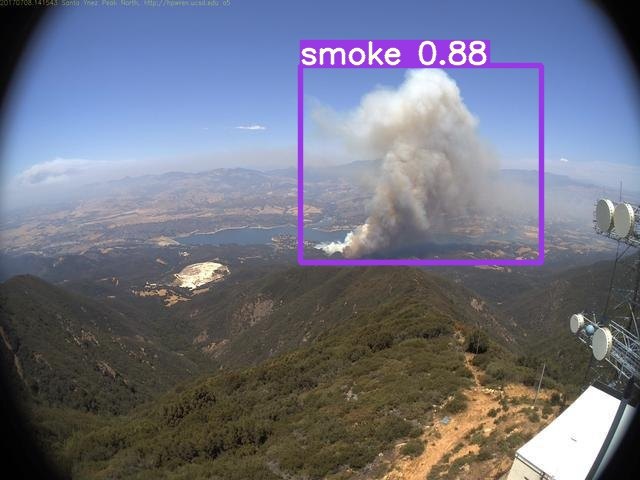

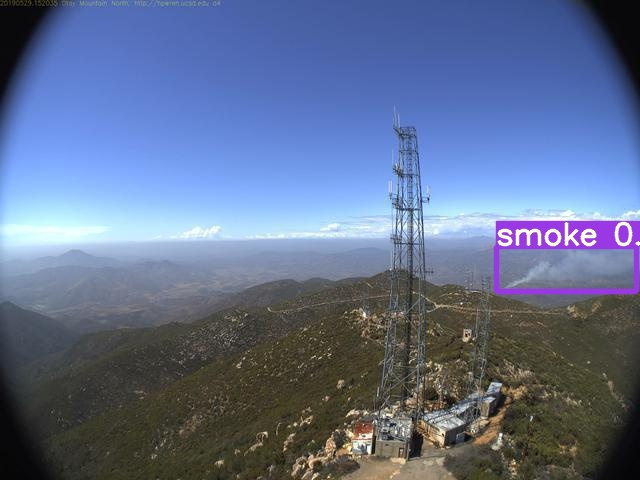

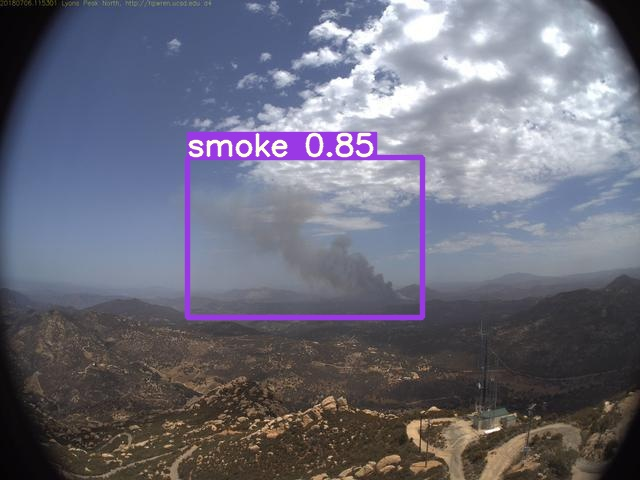

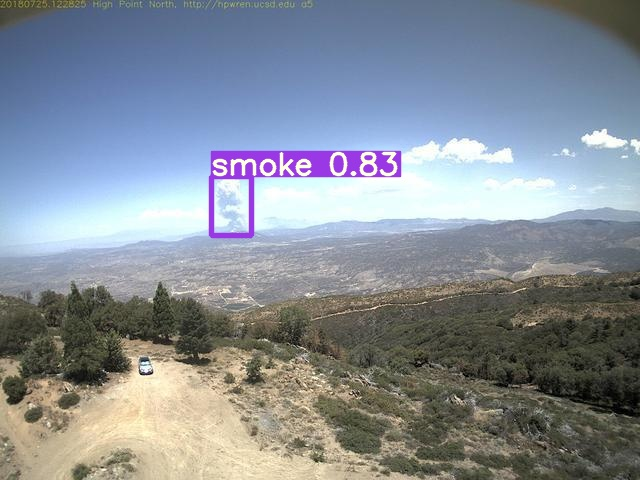

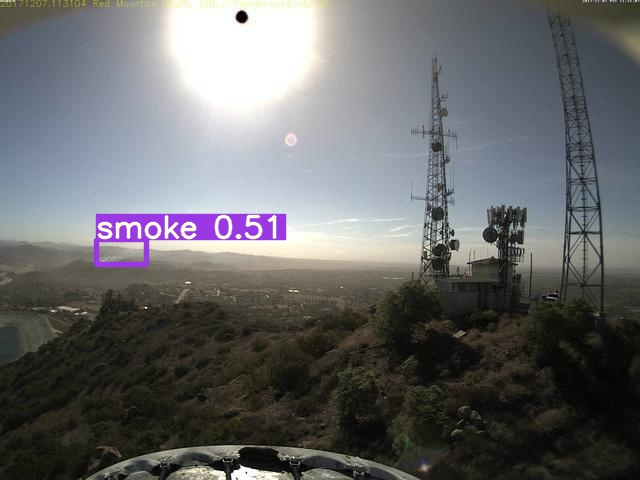

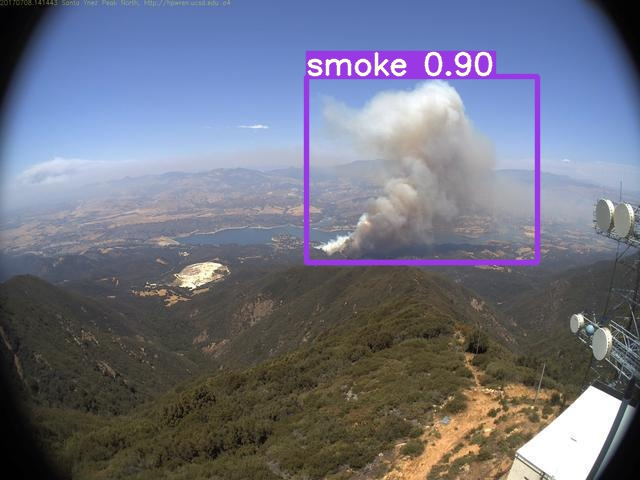

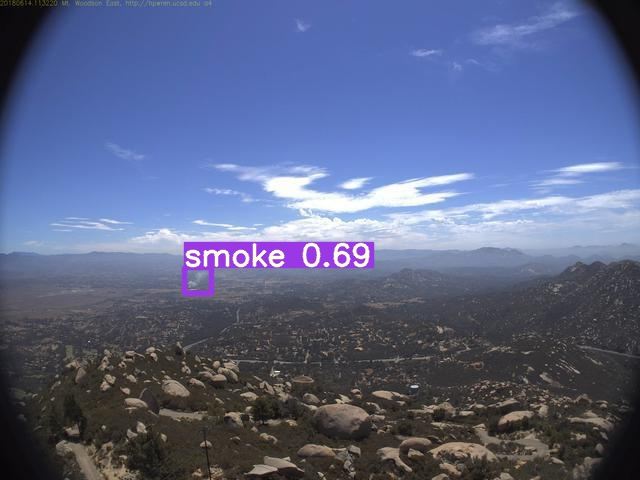

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

In [ ]:
!python detect.py --weights runs/exp0_yolov5s_results/weights/best.pt --source ../video4.mp4 --conf 0.4

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=640, iou_thres=0.45, output='inference/output', save_txt=False, source='../video4.mp4', update=False, view_img=False, weights=['runs/exp0_yolov5s_results/weights/best.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... 
Model Summary: 140 layers, 7.24652e+06 parameters, 0 gradients
video 1/1 (1/554) /content/video4.mp4: 384x640 Done. (0.012s)
video 1/1 (2/554) /content/video4.mp4: 384x640 Done. (0.014s)
video 1/1 (3/554) /content/video4.mp4: 384x640 Done. (0.012s)
video 1/1 (4/554) /content/video4.mp4: 384x640 Done. (0.010s)
video 1/1 (5/554) /content/video4.mp4: 384x640 Done. (0.015s)
video 1/1 (6/554) /content/video4.mp4: 384x640 Done. (0.011s)
video 1/1 (7/554) /content/video4.mp4: 384x640 Done. (0.012s)
video 1/1 (8/554) /content/video4.mp4: 384x640 Done. (0.011s)
video 1/1 (9/554) /content/video4.mp4: 384x640 Done. (0.011s)
